# NLP of Prime Minister Narendra Modi's Tweets during COVID-19

#### By Ridhit Bhura

In this project, I gathered a dataset from https://www.kaggle.com/saurabhshahane/twitter-sentiment-dataset and use the pretrained data to train a set of ~3500 tweets from Prime Minister Narendra Modi's personal twitter account. The process includes 1) twitter data extraction which can be found in the git directory for this project, 2) preprocessing of the test data (Modi tweets), 3) visualisation techniques and 4) Standard Scale & Random Forest Classifier model training. 

Due to migration to the M1 MacBook, the machine learning portion has bugs (specifically token labelling) which will be fixed shortly.
Nonetheless I was able to obtain >96% accuracy in model training for both the models. 

## Importing Packages

In [103]:
#Importing All Necessary Packages and Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [104]:
#Importing the relevant test and train datesets from their respective csv filepaths. 
train = pd.read_csv('/Users/ridhitbhura/Downloads/Twitter_Data.csv')
test = pd.read_csv('/Users/ridhitbhura/Downloads/twitterdatamodi.csv')

print(test.shape)
print(train.shape)

(3250, 3)
(162980, 2)


In [105]:
test.head()

,Date,Tweet_id,Tweet_Text
0,2021-08-11 03:30:29,1425298549093240832,Dr. Balaji Tambe will be remembered for his nu...
1,2021-08-11 03:28:57,1425298164534243328,Will be speaking at the #CIIAnnualSession2021 ...
2,2021-08-10 12:47:35,1425076359743688706,आज विश्व बायोफ्यूल दिवस पर हमें अपने लक्ष्यों ...
3,2021-08-10 12:47:27,1425076327397298178,बुंदेलखंड सहित पूरे यूपी और दूसरे राज्यों के ह...
4,2021-08-10 12:46:43,1425076140931043331,हमारी बेटियां राष्ट्रनिर्माण में व्यापक योगदान...


In [106]:
train.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## Cleaning The Datasets

In [107]:
test.isna().sum()

Date          0
Tweet_id      0
Tweet_Text    0
dtype: int64

In [108]:
train.isna().sum()

clean_text    4
category      7
dtype: int64

In [109]:
train[train['category'].isna()]

,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [110]:
train[train['clean_text'].isna()]


,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


In [111]:
train.drop(train[train['clean_text'].isna()].index, inplace=True)
train.drop(train[train['category'].isna()].index, inplace=True)

## Dataset Cleaning & Preprocessing

### Deleting Non-English Words 

In [112]:
def delete_non_english(var): 
    try: 
        var = re.sub(r'\W+', ' ', var)
        var = var.lower()
        var = var.replace("[^a-zA-Z]", " ")
        word_tokens = word_tokenize(var) 
        cleaned_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
        cleaned_word = [w + " " for w in cleaned_word]
        return "".join(cleaned_word)
    except:
        return np.nan

test["english_text"] = test.Tweet_Text.apply(delete_non_english)

In [113]:
test.head()

,Date,Tweet_id,Tweet_Text,english_text
0,2021-08-11 03:30:29,1425298549093240832,Dr. Balaji Tambe will be remembered for his nu...,dr balaji tambe will be remembered for his num...
1,2021-08-11 03:28:57,1425298164534243328,Will be speaking at the #CIIAnnualSession2021 ...,will be speaking at the ciiannualsession2021 t...
2,2021-08-10 12:47:35,1425076359743688706,आज विश्व बायोफ्यूल दिवस पर हमें अपने लक्ष्यों ...,https t co camdexfzzy
3,2021-08-10 12:47:27,1425076327397298178,बुंदेलखंड सहित पूरे यूपी और दूसरे राज्यों के ह...,2 0 https t co 7q4d7bjycu
4,2021-08-10 12:46:43,1425076140931043331,हमारी बेटियां राष्ट्रनिर्माण में व्यापक योगदान...,6 7 https t co gi9fm7cxmj


### Cleaning English Text

In [114]:
def clean_text(english_txt): 
    try: 
        word_tokens = word_tokenize(english_txt)
        cleaned_word = [w for w in word_tokens if not w in stop_words] 
        cleaned_word = [w + " " for w in cleaned_word]
        return "".join(cleaned_word)
    except:
        return np.nan

test["cleaned_text"] = test.english_text.apply(clean_text)

In [115]:
test.head()

,Date,Tweet_id,Tweet_Text,english_text,cleaned_text
0,2021-08-11 03:30:29,1425298549093240832,Dr. Balaji Tambe will be remembered for his nu...,dr balaji tambe will be remembered for his num...,NaN
1,2021-08-11 03:28:57,1425298164534243328,Will be speaking at the #CIIAnnualSession2021 ...,will be speaking at the ciiannualsession2021 t...,NaN
2,2021-08-10 12:47:35,1425076359743688706,आज विश्व बायोफ्यूल दिवस पर हमें अपने लक्ष्यों ...,https t co camdexfzzy,NaN
3,2021-08-10 12:47:27,1425076327397298178,बुंदेलखंड सहित पूरे यूपी और दूसरे राज्यों के ह...,2 0 https t co 7q4d7bjycu,NaN
4,2021-08-10 12:46:43,1425076140931043331,हमारी बेटियां राष्ट्रनिर्माण में व्यापक योगदान...,6 7 https t co gi9fm7cxmj,NaN


In [116]:
#Adopted code
def remove_link_email(txt):
    txt = re.sub(r"https t co \S+", "", txt)
    txt = txt.replace('\S*@\S*\s?', "")
    txt = re.sub(r'[^\w\s]', '', txt)
    return txt
test["final_text"] = test.english_text.apply(remove_link_email)

In [117]:
test.head()

,Date,Tweet_id,Tweet_Text,english_text,cleaned_text,final_text
0,2021-08-11 03:30:29,1425298549093240832,Dr. Balaji Tambe will be remembered for his nu...,dr balaji tambe will be remembered for his num...,NaN,dr balaji tambe will be remembered for his num...
1,2021-08-11 03:28:57,1425298164534243328,Will be speaking at the #CIIAnnualSession2021 ...,will be speaking at the ciiannualsession2021 t...,NaN,will be speaking at the ciiannualsession2021 t...
2,2021-08-10 12:47:35,1425076359743688706,आज विश्व बायोफ्यूल दिवस पर हमें अपने लक्ष्यों ...,https t co camdexfzzy,NaN,
3,2021-08-10 12:47:27,1425076327397298178,बुंदेलखंड सहित पूरे यूपी और दूसरे राज्यों के ह...,2 0 https t co 7q4d7bjycu,NaN,2 0
4,2021-08-10 12:46:43,1425076140931043331,हमारी बेटियां राष्ट्रनिर्माण में व्यापक योगदान...,6 7 https t co gi9fm7cxmj,NaN,6 7


## Visualisations

### Word Frequency

Text(0.5, 1.0, 'Word Occurunce Frequency - Top 20')

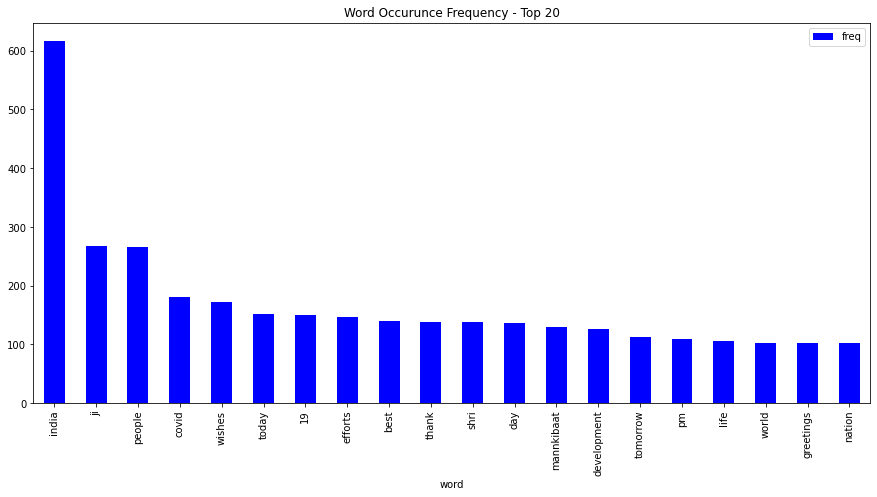

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(test.final_text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Word Occurunce Frequency - Top 20")

### Word Cloud

Text(0.5, 1.0, 'Most Common Words - Test Data')

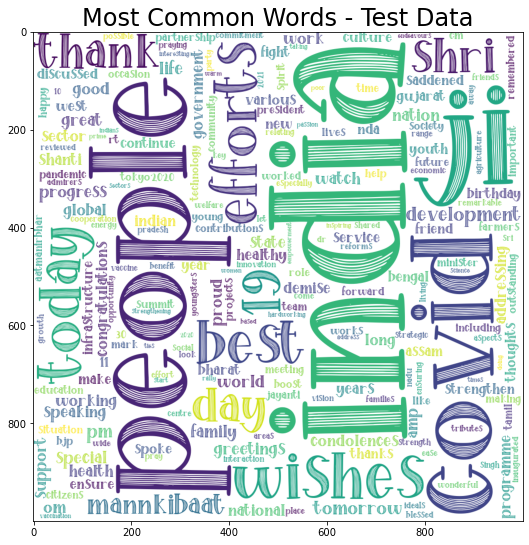

In [130]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000, font_path = '/Users/ridhitbhura/Downloads/fainland/Fainland.ttf').generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(12,9))
plt.imshow(wordcloud)
plt.title("Most Common Words - Test Data", fontsize = 24)

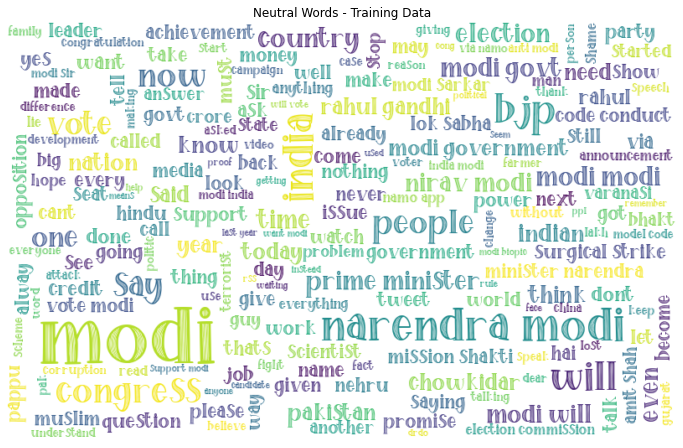

In [131]:
#Nuetral Words
normal_words =' '.join([text for text in train['clean_text'][train['category'] == 0]])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110, font_path = '/Users/ridhitbhura/Downloads/fainland/Fainland.ttf').generate(normal_words)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Words - Training Data')
plt.show()

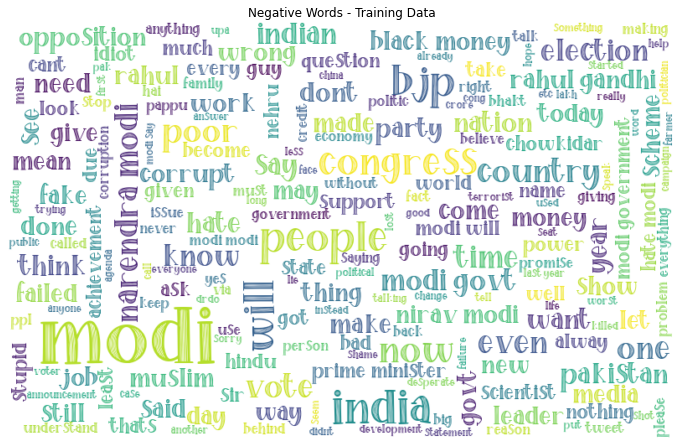

In [132]:
#Negative Words
normal_words =' '.join([text for text in train['clean_text'][train['category'] == -1]])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110, font_path = '/Users/ridhitbhura/Downloads/fainland/Fainland.ttf').generate(normal_words)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Words - Training Data')
plt.show()

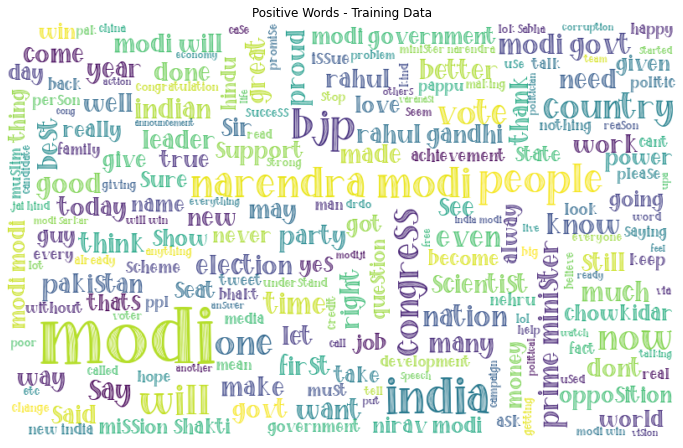

In [133]:
#Positive Words
normal_words =' '.join([text for text in train['clean_text'][train['category'] == 1]])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110,font_path = '/Users/ridhitbhura/Downloads/fainland/Fainland.ttf').generate(normal_words)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Words - Training Data')
plt.show()

### Hashtag Frequency Distribution

In [134]:
#Hashtag Collection
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags



In [136]:
# extracting hashtags from the test dataset
HT_test = hashtag_extract(test['Tweet_Text'])

# extracting hashtags from the training dataset by sentiment category 
HT_train_negative = hashtag_extract(train['clean_text'][train['category'] == -1])
HT_train_positive = hashtag_extract(train['clean_text'][train['category'] == 1])
HT_train_neutral = hashtag_extract(train['clean_text'][train['category'] == 0])

# removing nested attribute and simplifying the list
HT_test = sum(HT_test, [])
HT_train_negative = sum(HT_train_negative, [])
HT_train_positive = sum(HT_train_positive, [])
HT_train_neutral = sum(HT_train_neutral, [])



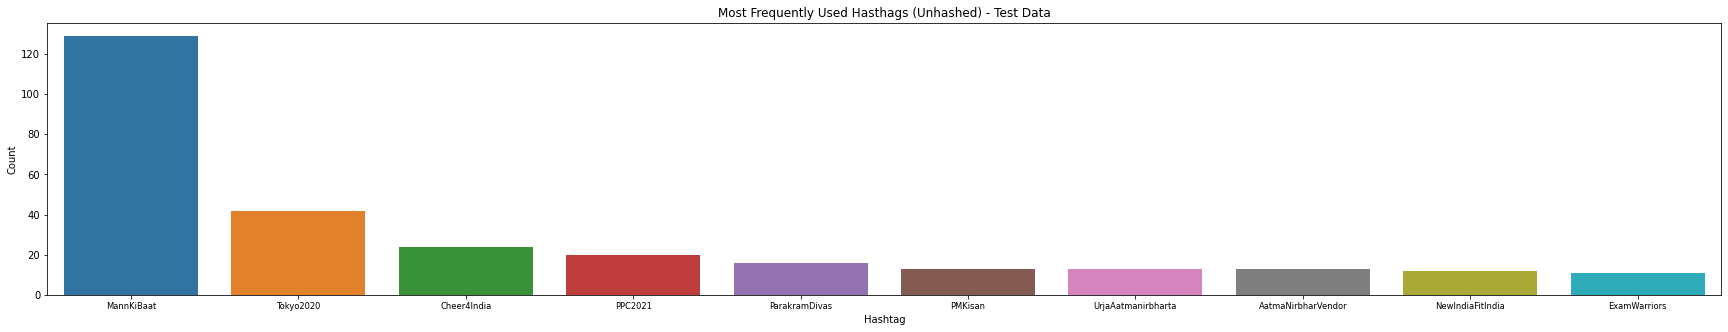

In [138]:
a = nltk.FreqDist(HT_test)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(30, 5))  # width:30, height:3
plt.xticks(range(1, len(a.keys())+1), a.keys(), size='small')
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Most Frequently Used Hasthags (Unhashed) - Test Data')
plt.show()

## Machine Learning Analysis

In [139]:
#Tokenizing the training dataset
tokenized_tweet = train['clean_text'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['clean_text']), epochs=20)


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 203640 words, keeping 20158 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 414580 words, keeping 30728 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 621301 words, keeping 39460 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 829648 words, keeping 47375 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 997806 words, keeping 52262 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 1194962 words, keeping 57961 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 1397783 words, keeping 63851 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 1607714 words, keepin

INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 19.85% examples, 270138 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 30.72% examples, 270008 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 40.27% examples, 265654 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 50.35% examples, 266931 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 60.27% examples, 266007 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 70.84% examples, 267513 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 81.20% examples, 268554 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 91.43% examples, 269384 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 8.62% examples, 236097 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 18.05% examples, 243226 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 28.11% examples, 246422 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 38.45% examples, 251030 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 48.49% examples, 255540 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 59.05% examples, 259035 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 69.61% examples, 261643 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 80.00% examples, 263555 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 6 - PROGRESS: at 90.24% examples, 264955 words/s, in_qsize 3, out_q

INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 43.24% examples, 277632 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 53.50% examples, 277551 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 63.95% examples, 276337 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 74.60% examples, 276470 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 84.84% examples, 276259 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 12 - PROGRESS: at 94.95% examples, 276266 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 12 : training on 3272532 raw words (2681495 effective words) took 9.7s, 276985 effective words/s
INFO:

INFO:gensim.models.base_any2vec:EPOCH 18 - PROGRESS: at 64.54% examples, 277968 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 18 - PROGRESS: at 75.50% examples, 279236 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 18 - PROGRESS: at 85.44% examples, 278095 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 18 - PROGRESS: at 95.59% examples, 278053 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 18 : training on 3272532 raw words (2682489 effective words) took 9.6s, 278619 effective words/s
INFO:gensim.models.base_any2vec:EPOCH 19 - PROGRESS: at 10.40% examples, 271816 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 19 - PROGRESS: at 20.45% examples, 274285 words/s, in_qsize 4, out_qsize 0
INFO:

(53632332, 65450640)

### Testing vectorisation of the model with test cases

In [140]:
model_w2v.wv.most_similar(positive = "election")

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


[('elections', 0.7921041250228882),
 ('poll', 0.7027072906494141),
 ('electionnothing', 0.6582773923873901),
 ('seasonthis', 0.6503581404685974),
 ('saidwar', 0.6482253074645996),
 ('electionsmodi', 0.6292448043823242),
 ('pmoelection', 0.62822425365448),
 ('creaworldnews', 0.6229242086410522),
 ('polls', 0.6045717000961304),
 ('nirhua', 0.6045700311660767)]

In [141]:
model_w2v.wv.most_similar(positive = "cancer")

[('spray', 0.6505127549171448),
 ('chemo', 0.6500874757766724),
 ('jaundice', 0.6216076016426086),
 ('cancers', 0.606437087059021),
 ('mcdonalds', 0.6050702929496765),
 ('cure', 0.5973175764083862),
 ('disease', 0.5862400531768799),
 ('vote4modi', 0.5667746067047119),
 ('festering', 0.5594819784164429),
 ('infection', 0.5559000372886658)]

In [142]:
model_w2v.wv.most_similar(positive = "victory")

[('landside', 0.6447207927703857),
 ('mrnamo’', 0.6383190751075745),
 ('win', 0.6343370676040649),
 ('winning', 0.6133577227592468),
 ('embolden', 0.611016035079956),
 ('vadodarabut', 0.6027681231498718),
 ('parliamentry', 0.5981441736221313),
 ('agai', 0.5740300416946411),
 ('300plus', 0.571171760559082),
 ('preying', 0.5676908493041992)]

### Labelling Tokenized Words

In [31]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.deprecated.doc2vec import LabeledSentence
LabeledSentence = gensim.models.deprecated.doc2vec.LabeledSentence

In [32]:

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

/var/folders/l9/6n1gmxmx515cfndb3gm2cyv40000gn/T/ipykernel_6830/2587694538.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


[LabeledSentence(words=['when', 'modi', 'promised', '“minimum', 'government', 'maximum', 'governance”', 'expected', 'him', 'begin', 'the', 'difficult', 'job', 'reforming', 'the', 'state', 'why', 'does', 'take', 'years', 'get', 'justice', 'state', 'should', 'and', 'not', 'business', 'and', 'should', 'exit', 'psus', 'and', 'temples'], tags=['tweet_0']),
 LabeledSentence(words=['talk', 'all', 'the', 'nonsense', 'and', 'continue', 'all', 'the', 'drama', 'will', 'vote', 'for', 'modi'], tags=['tweet_1']),
 LabeledSentence(words=['what', 'did', 'just', 'say', 'vote', 'for', 'modi', 'welcome', 'bjp', 'told', 'you', 'rahul', 'the', 'main', 'campaigner', 'for', 'modi', 'think', 'modi', 'should', 'just', 'relax'], tags=['tweet_2']),
 LabeledSentence(words=['asking', 'his', 'supporters', 'prefix', 'chowkidar', 'their', 'names', 'modi', 'did', 'great', 'service', 'now', 'there', 'confusion', 'what', 'read', 'what', 'not', 'now', 'crustal', 'clear', 'what', 'will', 'crass', 'filthy', 'nonsensical', 

In [33]:
print(train.shape)
print(test.shape)


(162969, 2)
(3250, 6)


In [34]:
train.shape

(162969, 2)

### Assigning test-train splits in the data

In [49]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ridhitbhura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
%%time
train_corpus = []
try:
    for i in range(0, 162969):
        review = re.sub('[^a-zA-Z]', ' ', train['clean_text'][i])
        review = review.lower()
        review = review.split()

        ps = PorterStemmer()
        # stemming
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        # joining them back with space
        review = ' '.join(review)
        train_corpus.append(review)
except KeyError:
    train_corpus.append(' ')


CPU times: user 170 ms, sys: 36.8 ms, total: 207 ms
Wall time: 226 ms


In [61]:
%%time
test_corpus = []

for i in range(0, 3250):
    review = re.sub('[^a-zA-Z]', ' ', test['english_text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    # joining them back with space
    review = ' '.join(review)
    test_corpus.append(review)


CPU times: user 3.44 s, sys: 644 ms, total: 4.08 s
Wall time: 4.11 s


In [62]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

(149, 1047)
(162969,)


In [63]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

(3250, 2500)


In [64]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

ValueError: Found input variables with inconsistent numbers of samples: [149, 162969]

In [65]:

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

NameError: name 'x_train' is not defined

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

NameError: name 'x_train' is not defined